In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import optuna
import json
import seaborn as sns
import yfinance as yf
from dateutil.relativedelta import relativedelta


import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

# where you save the data 
path = '../Data/BTC/'


In [9]:
def read_json_file(variable_name): 
    # Open the JSON file and read its content
    with open(path + variable_name + '.json', 'r') as file:
        data = json.load(file)
    df = pd.DataFrame(data[variable_name])
    df['x'] = df['x'].astype(int)
    df['date'] = pd.to_datetime(df['x'], unit='ms')
    df[variable_name] = df['y']
    df = df.drop(['x','y'], axis=1)
    return df


In [10]:
def calculate_weekly_average(df, period): 
    df.set_index('date', inplace=True)
    # Group by month and calculate the average trade volume
    monthly_avg_df = df.resample(period).mean()
    # Reset the index to have 'date' as a column again
    monthly_avg_df.reset_index(inplace=True)
    # Display the resulting DataFrame
    return monthly_avg_df

In [11]:
def create_df_from_column_names(first_column, names, period): 
    df = calculate_weekly_average(read_json_file(first_column), period)
    for i in names: 
        price = calculate_weekly_average(read_json_file(i), period)
        df = df.merge(price, on='date')
    return df


In [12]:
def calculate_change(df, new_name): 
    df[new_name] = (df[new_name].diff() / df[new_name]).astype('float64')
    # df = df.dropna()
    return df

# Data Preprocessing 

#### Inflation 


In [13]:
# CPI changes US data 
inflation = pd.read_csv(path + 'CPI_US.csv')
inflation['date'] = pd.to_datetime(inflation['DATE'])
inflation = inflation.drop(['DATE'], axis=1)
inflation = calculate_weekly_average(inflation, 'M')
inflation = calculate_change(inflation, 'CPIAUCSL')
inflation

,date,CPIAUCSL
0,1947-01-31,NaN
1,1947-02-28,0.006475
2,1947-03-31,0.017273
3,1947-04-30,0.000000
4,1947-05-31,-0.002278
...,...,...
923,2023-12-31,0.002326
924,2024-01-31,0.003045
925,2024-02-29,0.004401
926,2024-03-31,0.003766


#### Risk Free Rate  


In [14]:
# risk free rate US 3month t-bill
rf = pd.read_csv(path + '3m_tbill.csv')
rf['date'] = pd.to_datetime(rf['DATE'])
rf = rf[rf['DTB3'] != "."]
rf = rf.drop(['DATE'], axis=1)
rf['DTB3'] = rf['DTB3'].astype('float64')
rf = calculate_weekly_average(rf, 'W')
rf = calculate_change(rf, 'DTB3')
rf

,date,DTB3
0,1954-01-10,NaN
1,1954-01-17,-0.015601
2,1954-01-24,-0.154955
3,1954-01-31,-0.096838
4,1954-02-07,-0.018109
...,...,...
3668,2024-04-28,-0.000381
3669,2024-05-05,0.000762
3670,2024-05-12,0.000000
3671,2024-05-19,-0.000762


### Fear and Greed Index 

In [15]:
# Fear Greed index 
fear_greed = pd.read_csv(path + 'bitcoin_fear_greed.csv')
fear_greed['date'] = pd.to_datetime(fear_greed['date'], dayfirst=True)
# rf = rf[rf['DTB3'] != "."]
# rf = rf.drop(['DATE'], axis=1)
fear_greed['fear_greed'] = fear_greed['fear_greed'].astype('float64')
fear_greed = fear_greed.drop('value', axis=1)
fear_greed = calculate_weekly_average(fear_greed, 'W')
fear_greed = calculate_change(fear_greed, 'fear_greed')
fear_greed

,date,fear_greed
0,2018-02-04,NaN
1,2018-02-11,0.108645
2,2018-02-18,0.474201
3,2018-02-25,-0.190058
4,2018-03-04,-0.114007
...,...,...
324,2024-04-21,-0.141328
325,2024-04-28,0.046939
326,2024-05-05,-0.180723
327,2024-05-12,0.041570


In [16]:
# get SP500 data 
SP500 = yf.Ticker("^GSPC")
sp500 = SP500.history(period="max", interval="1d")
sp500.reset_index(inplace=True)
sp500['date'] = pd.to_datetime(sp500['Date'])
sp500['date'] = sp500['date'].dt.tz_localize(None)
sp500 = sp500[['date','Close']]
sp500 = calculate_weekly_average(sp500, 'W')
sp500 = calculate_change(sp500, 'Close')
sp500['sp500'] = sp500['Close']
sp500 = sp500.drop('Close' , axis=1)
sp500.drop
sp500

,date,sp500
0,1928-01-01,NaN
1,1928-01-08,0.000707
2,1928-01-15,-0.012519
3,1928-01-22,-0.006458
4,1928-01-29,0.016782
...,...,...
5028,2024-05-12,0.024262
5029,2024-05-19,0.014549
5030,2024-05-26,0.004998
5031,2024-06-02,-0.005753


In [17]:
# Gold Price 
gold = yf.Ticker("GC=F").history(period="max", interval="1d")
gold.reset_index(inplace=True)
gold['date'] = pd.to_datetime(gold['Date'])
gold['date'] = gold['date'].dt.tz_localize(None)
gold = gold[['date','Close']]
gold = calculate_weekly_average(gold, 'W')
gold = calculate_change(gold, 'Close')
gold['gold'] = gold['Close']
gold = gold.drop('Close' , axis=1)
gold

,date,gold
0,2000-09-03,NaN
1,2000-09-10,-0.007564
2,2000-09-17,-0.005959
3,2000-09-24,-0.006719
4,2000-10-01,0.015411
...,...,...
1236,2024-05-12,0.009863
1237,2024-05-19,0.018584
1238,2024-05-26,0.003517
1239,2024-06-02,-0.018004


In [62]:
# Inflation only works when period in is month or 'M' 
# Period default is Weeks 'W' 
period = 'W'
columns = [
    'difficulty', 
           'n-unique-addresses', 
           'trade-volume',
             'n-transactions-total', 
             'cost-per-transaction', 
            'n-transactions-excluding-popular', 
            'estimated-transaction-volume-usd'
            ]
columns = []
df = create_df_from_column_names('market-price', columns, period)

for i in columns: 
    df = calculate_change(df, i)

# # merge risk free rate data 
df = df.merge(rf, on='date')
# df = df.merge(gold, on='date')
df = df.merge(sp500, on='date')

# df = df.merge(fear_greed, on='date')

# # drop row where the price is 0 
df = df[df['market-price'] != 0]
df.reset_index(inplace=True)

# # calculate the return 
df['price'] = df['market-price']
df = calculate_change(df, 'market-price')
df['return'] = df['market-price']

# shift return up by 1 
df['return'] = df['return'].shift(-1)
df = df.drop(['index', 'market-price' ] , axis=1)
df = df.drop([df.index[0], df.index[-1]])
df = df.fillna(0)
df = df[~df.isin([np.inf, -np.inf]).any(axis=1)]


# Function used to turn the return in 0 and 1 for simplicity -> good when testing if the variables are working or not 
# def map_to_sign(x):
#     if x >= 0:
#         return 1
#     else:
#         return 0
# # Apply the function to the column
# df['return'] = df['return'].apply(map_to_sign)

df

,date,DTB3,sp500,price,return
1,2010-08-29,-0.012658,-0.024030,0.070000,-0.042553
2,2010-09-05,-0.144928,0.016151,0.067143,-0.093023
3,2010-09-12,0.014286,0.024048,0.061429,0.104167
4,2010-09-19,0.090909,0.020072,0.068571,0.000000
5,2010-09-26,0.049383,0.012644,0.068571,-0.142857
...,...,...,...,...,...
713,2024-04-21,0.001524,-0.031123,65410.795000,-0.013415
714,2024-04-28,-0.000381,0.007406,64544.908571,-0.013478
715,2024-05-05,0.000762,0.002408,63686.565714,-0.021063
716,2024-05-12,0.000000,0.024262,62372.788571,0.005209


In [264]:
correlation_matrix = df.corr()
#  Exclude diagonal elements
correlation_matrix_no_diagonal = correlation_matrix.mask(
    pd.DataFrame(np.eye(len(correlation_matrix), dtype=bool), correlation_matrix.index, correlation_matrix.columns))

# Check for high absolute correlation coefficients
threshold = 0.8 
highly_correlated_pairs = []

for i in range(len(correlation_matrix_no_diagonal.columns)):
    for j in range(i):
        correlation = correlation_matrix_no_diagonal.iloc[i, j]
        if abs(correlation) > threshold:
            pair = (correlation_matrix_no_diagonal.columns[i], correlation_matrix_no_diagonal.index[j], correlation)
            highly_correlated_pairs.append(pair)

if highly_correlated_pairs:
    print("\nHighly correlated pairs:")
    for pair in highly_correlated_pairs:
        print(f"{pair[0]} and {pair[1]}: {pair[2]}")
else:
    print("\nNo highly correlated pairs found.")


No highly correlated pairs found.


/var/folders/df/x7ngsr_15bx8pln6jsqgdxy00000gn/T/ipykernel_61924/1777331240.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


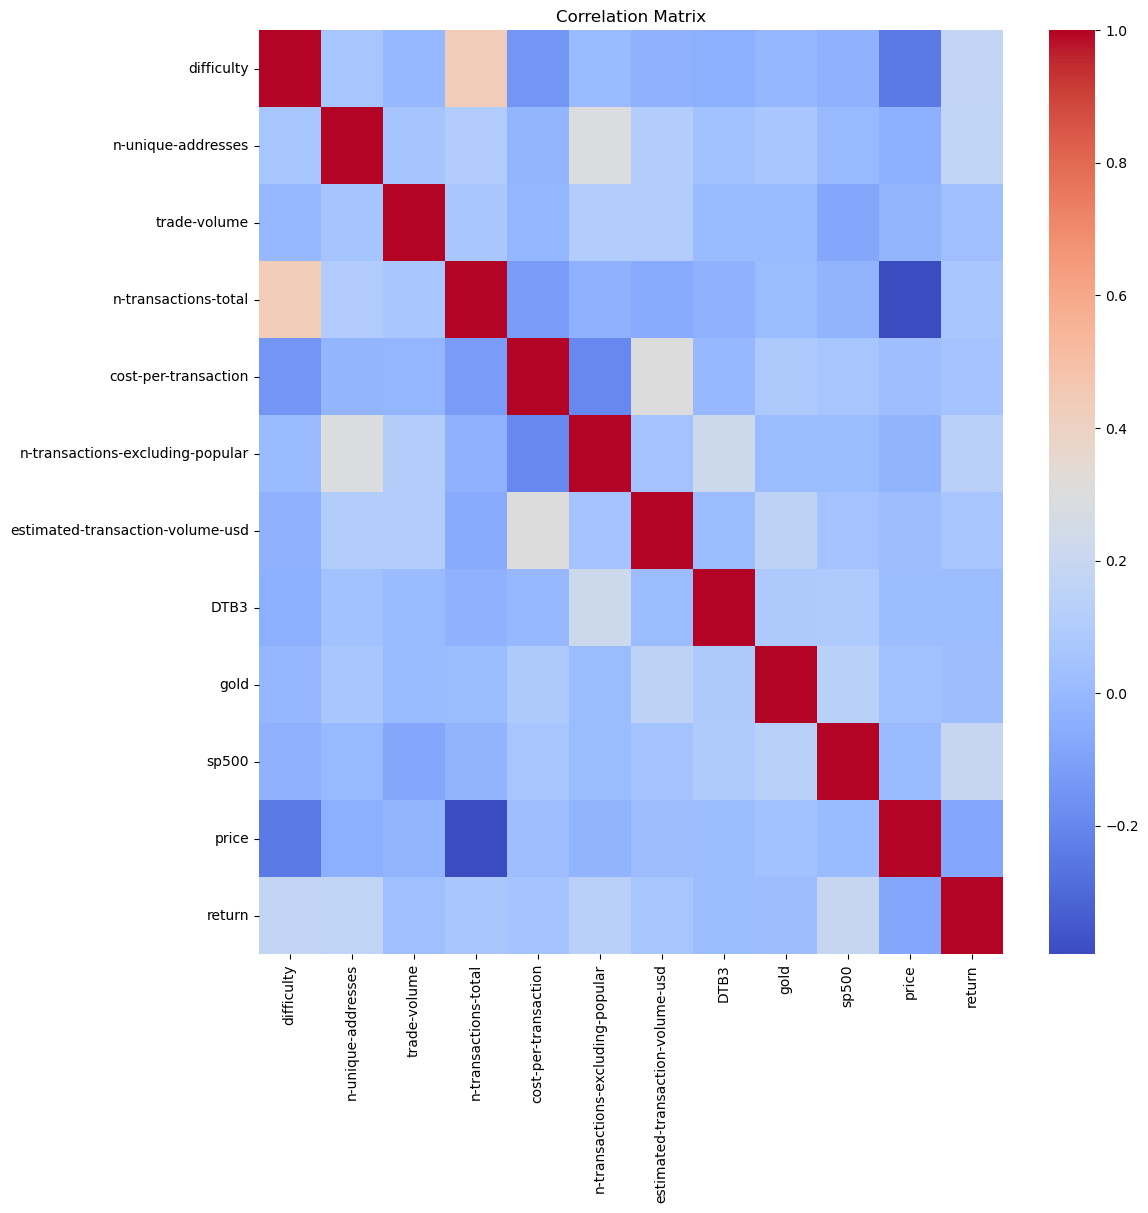

In [265]:
# Plot correlation matrix

plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



In [63]:
X = df.drop(columns=['return','date','price']) # everything except return info and IDs
y = df['return'] 

# make 20 years of training data
date = df['date']
training = (date <= '2019-03') # selects 
X_train, y_train = X.loc[training].values, y.loc[training].values 

# make 10 years of validation data
validation = (date > '2019-03') & (date <= '2020-03') 
X_val, y_val = X.loc[validation].values, y.loc[validation].values 

# make test data
test = (date > '2020-03') 
X_test, y_test = X.loc[test].values, y.loc[test].values 

print(" Shapes ")
print(X_train.shape,X_val.shape,X_test.shape)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# X_val = scaler.transform(X_val)

# # Convert to TensorFlow dataset
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
# validate_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)



 Shapes 
(444, 2) (53, 2) (220, 2)


## Cross Validation 

In [91]:

# Hyperparameters 
epochs = 100
patience = 5
batch_size = 32

# Using Optuna to cross validate hyper parameter 
input_dim = X_train.shape[1]
n_layers = 8
def create_model(trial):

    num_layers = 256
    # Suggest hyperparameters
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1])

    # l1_reg = trial.suggest_float('l1_reg', 1e-5, 1e-3, log=True)
    l1_reg = 1e-5
    # loss_function = trial.suggest_categorical('')

    optimizer = Adam(learning_rate=learning_rate)
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(input_dim,)))

    # add extra hidden layers 
    for i in range(n_layers): 
        model.add(Dense(num_layers,
                kernel_regularizer=regularizers.L1(l1_reg), 
                kernel_initializer = 'he_normal'))
        model.add(BatchNormalization())
        num_layers = int(num_layers / 2)
        
    # output layer 
    model.add(Dense(1, activation='linear',
                    kernel_regularizer=regularizers.L1(l1_reg), 
                    kernel_initializer = 'he_normal'))

    model.compile(loss='mse', 
                optimizer=optimizer,
                metrics = ['mse']) 
    return model

# Objective function for Optuna
def objective(trial):
    model = create_model(trial)
    
    # Use early stopping
    early_stopping = EarlyStopping(monitor='mse', patience=patience, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs,
        # batch_size,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate the model
    score = model.evaluate(X_val, y_val, verbose=0)
    return score[0]

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best trial
best_trial = study.best_trial

print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

In [21]:
# create the final model 
def create_nn(n_layers, input_dim, lamda, learning_rate):
    
    # max nodes in first layer 
    num_layers = 2 ** n_layers 
    optimizer = Adam(learning_rate=learning_rate)

    # init model 
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(input_dim,)))

    # add extra hidden layers 
    for i in range(n_layers): 
        # print(num_layers)
        model.add(Dense(num_layers,
                kernel_regularizer=regularizers.L1(lamda), 
                kernel_initializer = 'he_normal'))
        model.add(BatchNormalization())
        num_layers = int(num_layers / 2)
        
    # output layer 
    model.add(Dense(1, activation='linear',
                    kernel_regularizer=regularizers.L1(lamda), 
                    kernel_initializer = 'he_normal'))

# binary_crossentropy
    model.compile(loss='mse', 
                optimizer=optimizer,
                metrics = ['mse','accuracy']) 
    return model 

## Change this Chunk 

In [280]:
# test variable importance 

X_var_importance = X_test.copy() 

for i in range(len(X_var_importance)): 
    X_var_importance[i][9] = 0 

# X_var_importance
X_var_importance

array([[-2.41463242e-03,  9.39981391e-02, -1.14364617e+00, ...,
        -8.86842105e-01,  6.00290384e-03,  0.00000000e+00],
       [ 1.71704914e-02, -7.53152974e-02,  7.87280811e-01, ...,
        -1.15909091e+00, -1.64232764e-02,  0.00000000e+00],
       [ 4.80547669e-02, -2.67482859e-01, -1.36035512e+00, ...,
        -2.25925926e+00, -8.44618520e-02,  0.00000000e+00],
       ...,
       [ 2.97365191e-02,  9.29903040e-02, -8.93816571e-02, ...,
         1.52380952e-03,  1.62230205e-02,  0.00000000e+00],
       [ 3.74179764e-03, -2.48608356e-01, -1.10491946e+00, ...,
        -3.81097561e-04, -2.23195124e-02,  0.00000000e+00],
       [ 1.47057905e-02, -9.71257366e-02,  3.03247805e-01, ...,
         7.61614623e-04, -9.89174984e-03,  0.00000000e+00]])

## Run this Chunk 

In [65]:
lamda = 1e-5
epochs = 100
learning_rate = 0.01
patience = 5
batch_size = 10000
model = create_nn(4, X_test.shape[1], lamda , learning_rate)
total_R_OOS = [] 


ensemble = 10

months = 300
train_val_cut = '2019-03'
val_test_cut = '2020-03'

# Convert to datetime objects
train_val_cut = datetime.strptime('2019-03', '%Y-%m')
val_test_cut = datetime.strptime('2020-03', '%Y-%m')

# Implemented Expanding window 
for i in range(months):

    # print(f'Processing {i}', end='\r')

    # training = (date <= train_val_cut) & (date > (train_val_cut - relativedelta(months=48))) # selects 
    # # training = (date <= train_val_cut)
    # X_train, y_train = X.loc[training].values, y.loc[training].values 
    # # print('TRAIN .......' , training.sum())


    # # make 10 years of validation data
    # validation = (date > train_val_cut) & (date <= val_test_cut) 
    # X_val, y_val = X.loc[validation].values, y.loc[validation].values 
    # # print('VAL .......' , validation.sum())


    # # make test data
    # test = (date > val_test_cut) & (date <= val_test_cut + relativedelta(weeks=1))  
    # X_test, y_test = X.loc[test].values, y.loc[test].values 
    # # print('TEST .......' , test.sum())

    # history = model.fit(train_dataset, 
    #                         epochs=epochs, 
    #                         # batch_size=batch_size, 
    #                         verbose=False,
    #                         validation_data = validate_dataset,
    #                         callbacks = [EarlyStopping(patience = patience, restore_best_weights=True)])
    

    # Ensemble 
    predictions = []
    for en in range(ensemble):
        print(f' Processing {i} , Ensemble {en}', end='\r')

        history = model.fit(X_train, y_train , 
                                epochs=epochs, 
                                # batch_size=batch_size, 
                                verbose=False,
                                validation_data = (X_val,y_val),
                                callbacks = [EarlyStopping(patience = patience, restore_best_weights=True)])
        
        
        # current_prediction = model.predict(X_var_importance, verbose=0)
        current_prediction = model.predict(X_test, verbose=0)

        if len(predictions) == 0:
            predictions = current_prediction
        else: 
            predictions = (predictions + current_prediction)


    # predictions = model.predict(X_test)


    # df_predictions = pd.DataFrame(predictions, columns=['Prediction'])

    # print("MSE OOS: " , mean_squared_error(y_test, predictions))

    predictions = predictions / ensemble
    df_predictions = pd.DataFrame(predictions, columns=['Prediction'])
    df_predictions['Actual'] = y_test
    df_predictions['dif_squared'] = (df_predictions['Prediction'] - df_predictions['Actual'])**2
    df_predictions['actual_sqaured'] = (y_train.mean() - df_predictions['Actual'])**2
    R_OOS = 1 - (df_predictions['dif_squared'].sum()/df_predictions['actual_sqaured'].sum()) 
    # print("***** Mean R^2_OOS ", R_OOS)
    total_R_OOS.append(R_OOS)

    train_val_cut = train_val_cut + relativedelta(months=3)
    val_test_cut = val_test_cut + relativedelta(months=3)

print("TOTAL R^2 OOS " , np.mean(total_R_OOS))

TOTAL R^2 OOS  0.07471428357068433


In [59]:
total_R_OOS

[-3.5101624119225976,
 -4.114273427985062,
 -1.3315162951765673,
 -3.2017043934968905,
 -0.11714975245754289,
 -1.0431311908247514,
 -269.41869508043874,
 -0.3513836651147164,
 0.4525291645449093,
 -22.741333848417835,
 0.9334470850949506,
 0.988204828984159]

# Trading Strategy 

1. Compare with buy and hold
2. change trading strategy to depend on the confidence / return predicted 
3. Subtract out the trading cost 


In [45]:
lamda = 1e-5
epochs = 100
learning_rate = 0.01
patience = 5
batch_size = 10000
model = create_nn(4, X_test.shape[1], lamda , learning_rate)
total_R_OOS = [] 

# Ensemble Models
ensemble = 10
model_array = [] 
for i in range(ensemble): 
    model.fit(X_train, y_train, 
                epochs=epochs, 
                # batch_size=batch_size, 
                verbose=False,
                validation_data = (X_val, y_val),
                callbacks = [EarlyStopping(patience = patience, restore_best_weights=True)])
    model_array.append(model)




# price in each period 
df_strategy_test = df['price'].loc[test].values

# status 0 is not in position , 1 is in position 
commission = True 
commission_rate = 0.01 / 100 

# collect results 
trading_trial = 1
trial_results = [] 

wealth_mem = [] 

for trial_no in range(trading_trial): 

    print(f'Processing {trial_no}', end='\r')

    wealth_mem.append([])
    status = 0 
    wealth = 100
    unit = 0 
    
    for i in range(X_test.shape[0]):

            predictions = [] 
            reshaped_array = np.array(X_test[i]).reshape(1, X_test.shape[1])

            # Implement Ensemble model for prediction to reduce variance in prediction outcomes 
            for model_no in range(ensemble):
                current_prediction = model_array[model_no].predict(reshaped_array, verbose=0)
                if len(predictions) == 0:
                    predictions = current_prediction
                else: 
                    predictions = (predictions + current_prediction)
            
            # predictions = model.predict(reshaped_array)
            predictions = predictions / 10

            # Action of trader 
            # If there's an open position 
            if status == 1: 
                # if we predict the next price is going to go lower, we sell now to take profit 
                if predictions <= 0: 
                        # sell 
                        status = 0 
                        wealth = unit * df_strategy_test[i]
                        if commission: 
                            wealth = wealth * (1 - commission_rate) 
                        unit = 0 
            
                # else keep the position open for more profit 
            # If status == 0 , there's no open position 
            else: 
                # if the prediction is positive, then open the position
                if predictions > 0: 
                    status = 1
                    if commission: 
                         wealth = wealth * (1 - commission_rate) 
                    unit = wealth / df_strategy_test[i]
                # else no point in buying in 
            
            # calculate wealth 
            if unit != 0 : 
                 wealth_mem[trial_no].append(df_strategy_test[i] * unit)
            else: 
                 wealth_mem[trial_no].append(wealth)
    
    trial_results.append((wealth - 100)/100)
print("Performance OOS : ", np.mean(trial_results))

Performance OOS :  16.684214466499874


In [43]:
print(np.mean(trial_results))
print((df_strategy_test[-1] - df_strategy_test[0]) / df_strategy_test[0])

32.6131664383619
6.3040628593205055


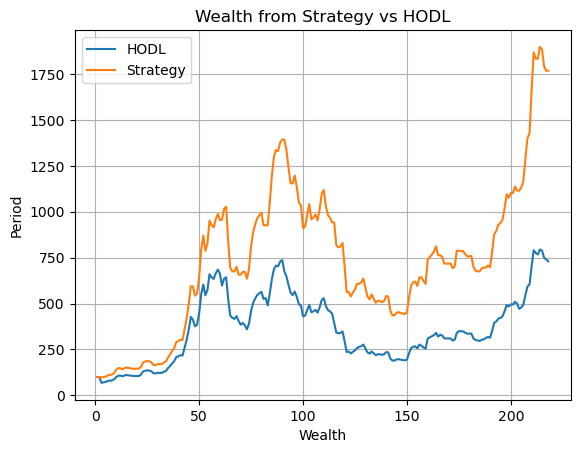

In [ ]:
# wealth_mem
# x = list(range(1, X_test.shape[0] + 1))
y1 = df_strategy_test * (100 / df_strategy_test[0])
y2 = wealth_mem[0]


y_data = [2, 4, 6, 8, 10]
x1_data = [1, 3, 5, 7, 9]
x2_data = [2, 4, 6, 8, 10]

# Create the line plot
plt.plot(test, y1, label='HODL')
plt.plot(test, y2, label='Strategy')

# Add labels and title
plt.xlabel('Wealth')
plt.ylabel('Period')
plt.title('Wealth from Strategy vs HODL')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
